In [ ]:
# If notebook is run on google colab

from google.colab import drive
drive.mount('/content/drive')

In [17]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import tslearn
import seaborn as sns

from math import ceil

from sklearn.preprocessing import LabelEncoder
# from tqdm import tqdm


from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [8]:
path = "../data/"

calendar_df = pd.read_csv(path+'calendar_afcs2023.csv')
sell_prices_df = pd.read_csv(path+'sell_prices_afcs2023.csv')
sales_test = pd.read_csv(path+'sales_test_validation_afcs2022.csv')
sales_train = pd.read_csv(path+'sales_train_validation_afcs2023.csv')
sample_submission = pd.read_csv(path+'sell_prices_afcs2023.csv')

In [9]:
date_range = pd.Series(pd.date_range(start="2011-01-29", end="2016-06-19", freq='D')).dt.strftime('%m/%d/%Y').to_list()
date_range.insert(0, "id")

In [10]:
sales_train.columns = date_range[:len(sales_train.columns)]
sales_train[['Food', "Loc1", "Loc2", "Type"]] = sales_train.id.str.rsplit("_", n=3, expand=True)
sales_train = sales_train.drop("id", axis=1)
sales_train = sales_train.melt(id_vars=['Food', "Loc1", "Loc2", "Type"], var_name="date", value_name="sales_amount")
sales_train["date"] = pd.to_datetime(sales_train["date"])

In [11]:
sales_train['date'] = pd.to_datetime(sales_train['date'])
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Merge the DataFrames on the 'date' column
sales_train = pd.merge(sales_train, calendar_df, on='date')

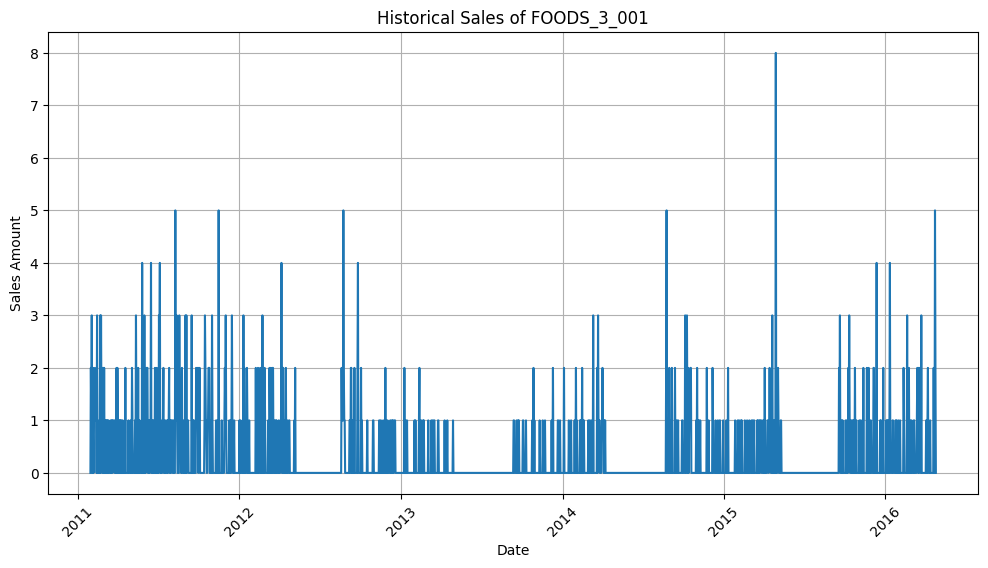

In [ ]:
import matplotlib.pyplot as plt


df= sales_train

# Assuming your DataFrame is named df
# Filter the DataFrame for the product 'FOODS_3_001'
product_sales = df[df['Food'] == 'FOODS_3_001']

# Sort the DataFrame by date
product_sales = product_sales.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(product_sales['date'], product_sales['sales_amount'])
plt.title('Historical Sales of FOODS_3_001')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)  # Rotates the date labels for better readability
plt.grid(True)
plt.show()


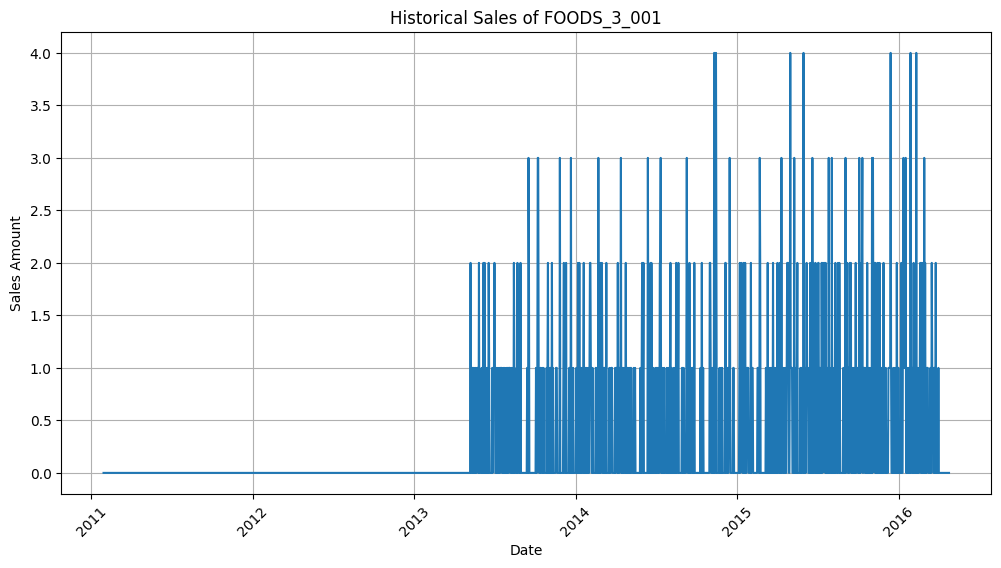

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df= sales_train

# Assuming your DataFrame is named df
# Filter the DataFrame for the product 'FOODS_3_001'
product_sales = df[df['Food'] == 'FOODS_3_010']

# Sort the DataFrame by date
product_sales = product_sales.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(product_sales['date'], product_sales['sales_amount'])
plt.title('Historical Sales of FOODS_3_001')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)  # Rotates the date labels for better readability
plt.grid(True)
plt.show()

### clustering of similar patterns in sales data, based on euclidian distance

In [27]:
# Assuming 'df' is your DataFrame and 'sales_amount' is your target variable
# Reshape the data into a time series format
# Here, we assume the data is already sorted by date
df= sales_train
unique_products = df['Food'].unique()
time_series_data = []

for product in unique_products:
    product_data = df[df['Food'] == product]['sales_amount'].values
    time_series_data.append(product_data)

# Convert to a time series dataset
formatted_dataset = to_time_series_dataset(time_series_data)

# Normalize the time series data
scaler = TimeSeriesScalerMeanVariance()
scaled_dataset = scaler.fit_transform(formatted_dataset)

# Clustering
n_clusters = 10  # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=4)
clusters = model.fit_predict(scaled_dataset)

# Analysis
for i in range(n_clusters):
    print(f"Cluster {i}:")
    cluster_members = unique_products[clusters == i]
    print(list(cluster_members))


Cluster 0:
['FOODS_3_002', 'FOODS_3_044', 'FOODS_3_051', 'FOODS_3_053', 'FOODS_3_058', 'FOODS_3_073', 'FOODS_3_084', 'FOODS_3_085', 'FOODS_3_105', 'FOODS_3_110', 'FOODS_3_122', 'FOODS_3_171', 'FOODS_3_218', 'FOODS_3_220', 'FOODS_3_260', 'FOODS_3_267', 'FOODS_3_300', 'FOODS_3_306', 'FOODS_3_312', 'FOODS_3_330', 'FOODS_3_340', 'FOODS_3_349', 'FOODS_3_352', 'FOODS_3_358', 'FOODS_3_359', 'FOODS_3_364', 'FOODS_3_367', 'FOODS_3_379', 'FOODS_3_409', 'FOODS_3_429', 'FOODS_3_436', 'FOODS_3_443', 'FOODS_3_515', 'FOODS_3_518', 'FOODS_3_519', 'FOODS_3_523', 'FOODS_3_525', 'FOODS_3_527', 'FOODS_3_532', 'FOODS_3_549', 'FOODS_3_553', 'FOODS_3_566', 'FOODS_3_573', 'FOODS_3_576', 'FOODS_3_593', 'FOODS_3_606', 'FOODS_3_617', 'FOODS_3_626', 'FOODS_3_636', 'FOODS_3_639', 'FOODS_3_641', 'FOODS_3_653', 'FOODS_3_659', 'FOODS_3_662', 'FOODS_3_695', 'FOODS_3_733', 'FOODS_3_737', 'FOODS_3_756', 'FOODS_3_758', 'FOODS_3_774', 'FOODS_3_776', 'FOODS_3_790']
Cluster 1:
['FOODS_3_012', 'FOODS_3_021', 'FOODS_3_030', '

<Axes: xlabel='date', ylabel='sales_amount'>

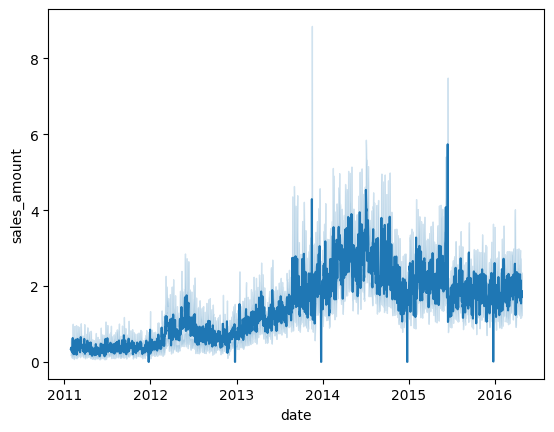

In [26]:
members = df[df['Food'].isin(cluster_members)]
sns.lineplot(data=members, x="date", y="sales_amount")

In [23]:
members

,Food,Loc1,Loc2,Type,date,sales_amount,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
1,FOODS_3_002,TX,3,validation,2011-01-29,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
3,FOODS_3_004,TX,3,validation,2011-01-29,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
9,FOODS_3_010,TX,3,validation,2011-01-29,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
21,FOODS_3_022,TX,3,validation,2011-01-29,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
23,FOODS_3_024,TX,3,validation,2011-01-29,0,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574389,FOODS_3_818,TX,3,validation,2016-04-24,2,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574391,FOODS_3_820,TX,3,validation,2016-04-24,3,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574392,FOODS_3_821,TX,3,validation,2016-04-24,0,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0
1574396,FOODS_3_825,TX,3,validation,2016-04-24,0,11613,Sunday,2,4,2016,NaN,NaN,NaN,NaN,0


In [ ]:
# Assuming 'df' is your DataFrame and 'sales_amount' is your target variable
# Reshape the data into a time series format
unique_products = df['Food'].unique()
time_series_data = []

for product in unique_products:
    product_data = df[df['Food'] == product]['sales_amount'].values
    time_series_data.append(product_data)

# Convert to a time series dataset
formatted_dataset = to_time_series_dataset(time_series_data)

# Normalize the time series data
scaler = TimeSeriesScalerMeanVariance()
scaled_dataset = scaler.fit_transform(formatted_dataset)

# Clustering with DTW
n_clusters = 10  # Number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
clusters = model.fit_predict(scaled_dataset)

# Analysis
for i in range(n_clusters):
    print(f"Cluster {i}:")
    cluster_members = unique_products[clusters == i]
    print(list(cluster_members))


NameError: ignored

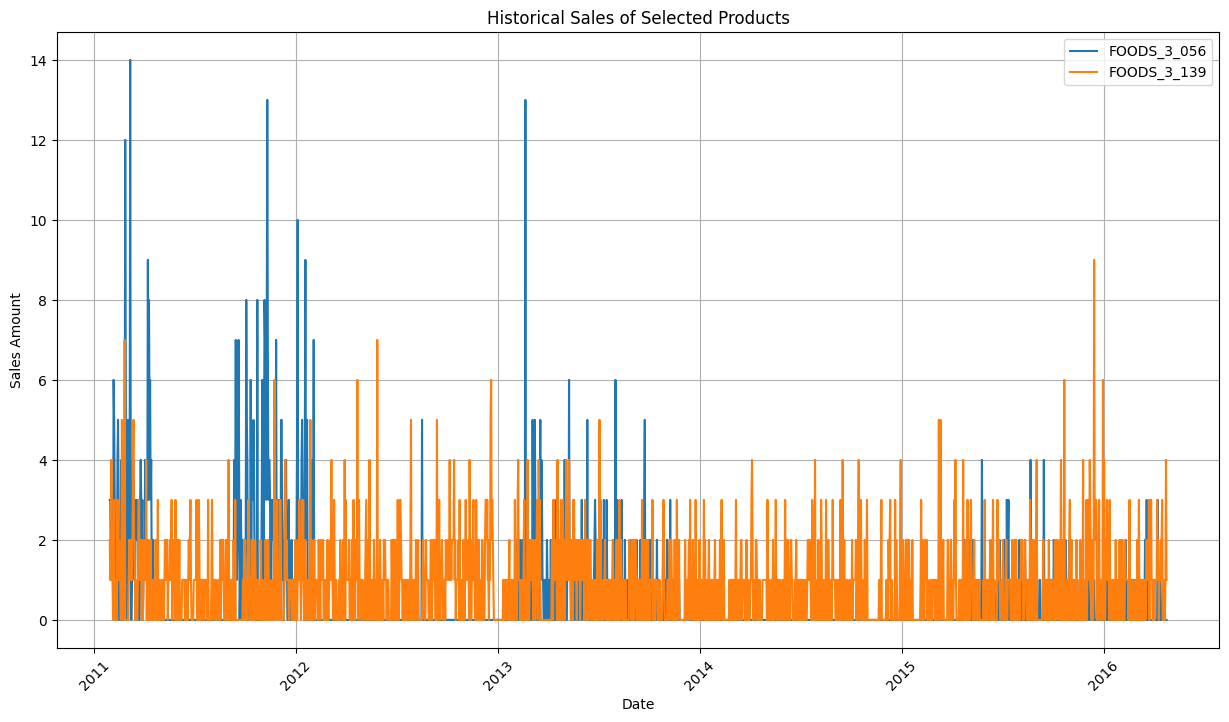

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named df
df = sales_train

# List of products to plot
products = ['FOODS_3_056', 'FOODS_3_139']

# Set up the plot
plt.figure(figsize=(15, 8))

# Loop through each product and plot
for product in products:
    product_sales = df[df['Food'] == product]
    product_sales = product_sales.sort_values('date')
    plt.plot(product_sales['date'], product_sales['sales_amount'], label=product)

# Adding plot title and labels
plt.title('Historical Sales of Selected Products')
plt.xlabel('Date')
plt.ylabel('Sales Amount')

# Improve readability
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


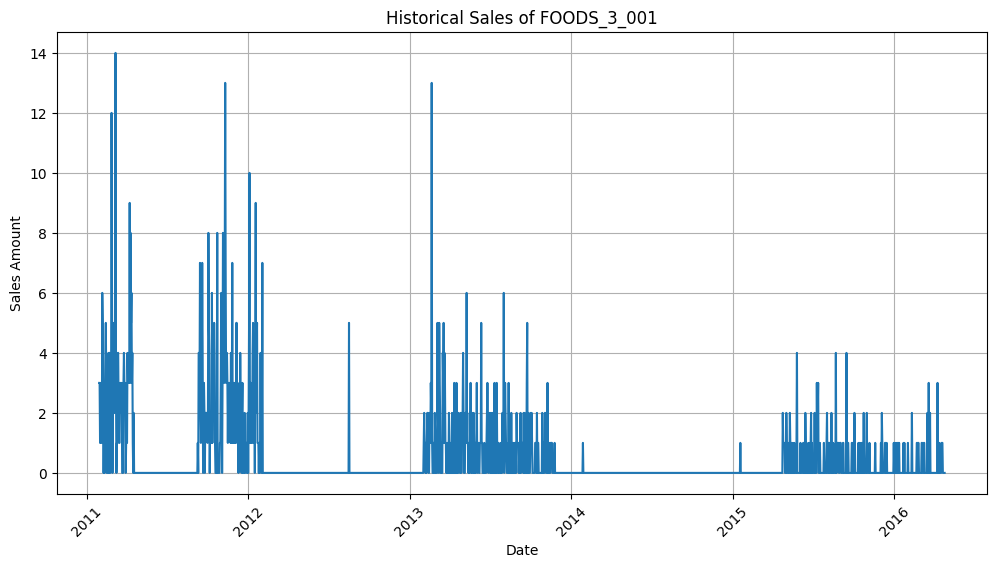

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df= sales_train

# Assuming your DataFrame is named df
# Filter the DataFrame for the product 'FOODS_3_001'
product_sales = df[df['Food'] == 'FOODS_3_056']

# Sort the DataFrame by date
product_sales = product_sales.sort_values('date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(product_sales['date'], product_sales['sales_amount'])
plt.title('Historical Sales of FOODS_3_001')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)  # Rotates the date labels for better readability
plt.grid(True)
plt.show()

In [ ]:
# Display unique values in 'Loc1'
print("Unique values in 'Loc1':", sales_train['Loc1'].unique())

# Display unique values in 'Loc2'
print("Unique values in 'Loc2':", sales_train['Loc2'].unique())

# Drop the columns after checking the unique values
sales_train = sales_train.drop(columns=['Loc1', 'Loc2'])


Unique values in 'Loc1': ['TX']
Unique values in 'Loc2': ['3']


In [ ]:
# Merge the DataFrames on the 'week' column
sales_train = pd.merge(sales_train, sell_prices_df, on='wm_yr_wk')
sales_train.head()

In [ ]:
########################### Vars
#################################################################################
TARGET = 'sales'         # Our main target
END_TRAIN = 1941         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns

In [ ]:
hc = tslearn.clustering.HierarchicalClustering(metric='euclidean')

# Fit the model to the data
hc.fit(X)

# Get the cluster labels for each time series
labels = hc.labels_